# Hyperparameter optimization: BERT embeddings (3 kinds)

Grand et al data

Hyperparameter optimization on a development set.

# Reading the data

## BERT

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
# global settings
num_randseeds = 3
feature_dim = 1024
whichbert = "l16"

In [3]:
bert_large_vecs_paths = { "ltop4-plus16" : "bert-large-uncased.npz",
                          "ltop4" : "bert-large-uncased.top4layers.npz",
                          "l16" : "bert-large-uncased_layer16.npz" }

print("using BERT", bert_large_vecs_paths[whichbert])

word_vectors = {}
data = np.load(bert_large_vecs_paths[whichbert])

for word in data:
    vector = data[word]
    if ' ' in word:
        first, second = word.split()
        if 'north' in first and 'dakota' in second:
            word = first + '_' + second
            print(word)
            word_vectors[word] = vector
        else:
            word = first + '-' + second
            print(word)
            word_vectors[word] = vector
    else:
        word_vectors[word] = vector

using BERT bert-large-uncased_layer16.npz
north-carolina
ping-pong
hong-kong
north_dakota
rhode-island
new-york
south-dakota
los-angeles
west-virginia
new-jersey
san-francisco
new-hampshire
south-carolina
new-mexico


## Grand features

In [4]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [5]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [6]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = np.random.randint(method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

We assume results that are dictionaries. 

First, a function for aggregating results by particular labels, into a single dictionary. For example, when results are aggregated by category and feature, the result will be a dictionary whose keys are category/feature tuples, and the values are lists of result dictionaries. 

Second, a function that computes mean, median, and standard deviation, over a list of result dictionaries, for a given labels.

In [7]:
from collections import defaultdict
import statistics

# given a list of results dictionaries, 
# group them by the given dictionary keys
def eval_aggregate_by(evals, keylabels):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        key = tuple([str(e[k]) for k in keylabels])
        bydataset_eval[ key ].append(e)
        
    return bydataset_eval


# given a list of results dictionaries,
# compute mean, median and standard deviation over values for a particular key
def eval_summary_by(evals, keylabel):
    vals = [e[keylabel] for e in evals if e[keylabel] is not None]
    
    return (statistics.mean(vals), statistics.median(vals), statistics.stdev(vals))

# given a dictionary of results (parameters -> result dictionary list),
# * for each parameter setting, aggregate by cateogy and feature
# * for each category/feature, compute mean ocp and mse values
# * for the parameter setting, compute mean and sd ocp and mse over all category/feature pairs
def eval_hyper(results, parameternames):
    # output dictionary
    results_byparam = [ ]

    # iterate over parameter settings
    for theseresults in results.values():
        # extract parameters
        this_dict = dict([(par, theseresults[0][par]) for par in parameternames])
        
        # aggregate by condition = by category and feature
        results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
        
        # compute mean ocp and mse values.
        # ocp: we use mean for each condition.
        # mse: we use median for each condition
        ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
        mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]

        # compute mean and standard deviation over ocps and mses
        this_dict["ocp_mean"] = statistics.mean(ocps)
        this_dict["ocp_sd"] = statistics.stdev(ocps)
        this_dict["msemed_mean"] = statistics.mean(mses)
        this_dict["msemed_sd"] = statistics.stdev(mses)
        
        results_byparam.append(this_dict)
        
    return results_byparam


# Making a development set

In [8]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests n times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [9]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(oval, jval, ocp_mean, mse_med)
            

            for r in theseresults:
                r.update({"offset":oval, "j": jval})
                results[ (str(oval), str(jval))].append(r)
    


0.1 True 0.4705079953204238 1039.8149313699657
0.2 True 0.4895805483631609 1880.801223761126
0.3 True 0.49924282323216324 1628.7035825230346
0.4 True 0.502964894910564 1238.898193324877
0.5 True 0.5074705748201351 1763.6104393685546
0.6 True 0.4832921685993467 1438.253141712858
0.7 True 0.4715819504021992 1493.096650377559
0.7999999999999999 True 0.49763589770799677 1146.2901929074292
0.8999999999999999 True 0.4981857998506228 1557.0102670986028
0.9999999999999999 True 0.48342038137337284 1967.586525560454
1.0999999999999999 True 0.4746004802061716 2003.2341110511452
1.2 True 0.4875851339944837 1934.315410068415
1.3 True 0.4772287428472527 1798.3590301309787
1.4 True 0.5102702665198249 1731.5419334993246
1.5 True 0.49221452935494764 1560.6553529568969
1.5999999999999999 True 0.5122505001428098 1539.0014647801383
1.7 True 0.4821849321307191 1541.0989171674973
1.8 True 0.4847036477309602 1165.4069884833857
1.9 True 0.4789538671430143 1234.1760518629067
2.0 True 0.49073232471954287 1474.2

In [10]:
df = pd.DataFrame(eval_hyper(results, ["offset", "j"]))
df.head()


,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.1,True,0.500021,0.034504,973.206999,640.581928
1,0.2,True,0.498474,0.036403,1031.702120,810.715926
2,0.3,True,0.511791,0.030845,1273.320970,1270.253045
3,0.4,True,0.506505,0.041268,803.039916,688.775814
4,0.5,True,0.504615,0.025995,1181.444696,1037.166808


We plot mean OC_P values, with standard deviation. 

<AxesSubplot: xlabel='offset'>

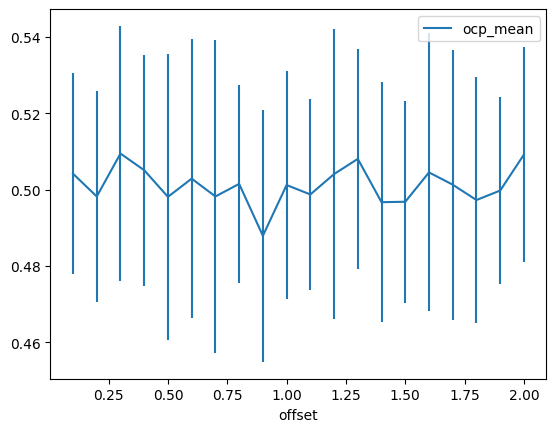

In [11]:
%matplotlib inline
df[df.j == False].plot(y = "ocp_mean",x = "offset", yerr = "ocp_sd")

<AxesSubplot: xlabel='offset'>

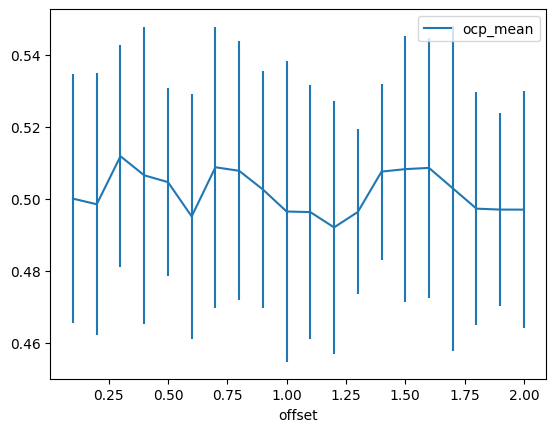

In [12]:
df[df.j == True].plot(y = "ocp_mean", x = "offset", yerr = "ocp_sd")

We plot mean values of median MSE, with standard deviation. 

<AxesSubplot: xlabel='offset'>

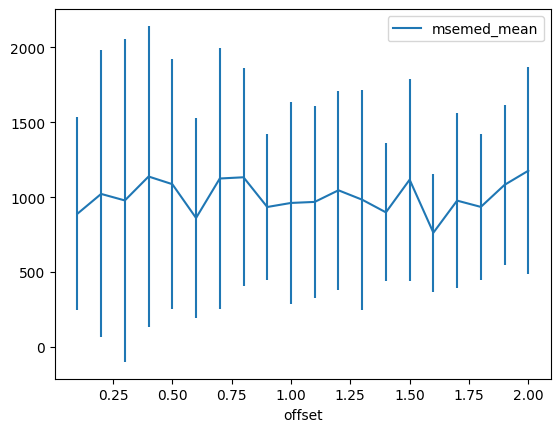

In [13]:
df[df.j == False].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

<AxesSubplot: xlabel='offset'>

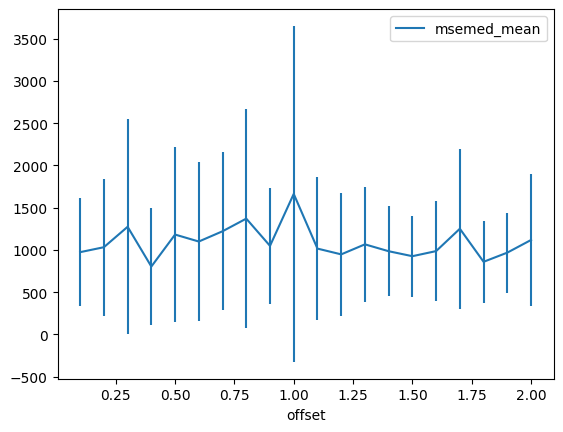

In [14]:
df[df.j == True].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

### Parameters for seeds as words

**BERT, last 4 layers plus layer 16**:
The differences in OC_OP are small compared to the error bars: It basically doesn't matter which value for the offset we pick. Jitter or no jitter makes no clear difference. IOn terms of MSE, the difference in results is clearly dwarfed by the error bars: It does not matter at all which values we pick. 

Because we need to pick some value, we pick the best OC_P, which also has a decent MSE: **offset of 0.3, no jitter**. 

**BERT, last 4 layers**:


The best settings by OC_P are quite different from best settings by MSE. Error bars are horrible for both measures, so they are both no good. So we go with OC_P because we went with OC_P for the previous model and pick **offset 0.7, with jitter**. There doesn't seem to be a difference between results with and without jitter. 

**BERT, layer 16**

We go with the bset by OC_P, which is **offset 0.3 with jitter**. Again, the choice doesn't matter much because differences in performance are dwarfed by differences in error bars.


In [15]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
2,0.3,True,0.511791,0.030845,1273.320970,1270.253045
22,0.3,False,0.509462,0.033440,978.111317,1077.791703
39,2.0,False,0.509199,0.028146,1176.407376,692.485944
6,0.7,True,0.508737,0.039011,1220.434023,936.677679
15,1.6,True,0.508557,0.036039,985.805614,595.440528
14,1.5,True,0.508216,0.036825,925.401730,480.574687
32,1.3,False,0.508068,0.028836,982.998154,734.690222
7,0.8,True,0.507749,0.035909,1370.018565,1292.008867
13,1.4,True,0.507527,0.024390,984.208396,529.740030
3,0.4,True,0.506505,0.041268,803.039916,688.775814


In [16]:
df.sort_values(by = "msemed_mean", ascending = True).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
35,1.6,False,0.504529,0.036425,762.810969,393.404251
3,0.4,True,0.506505,0.041268,803.039916,688.775814
17,1.8,True,0.497250,0.032390,858.988947,488.794494
25,0.6,False,0.502895,0.036627,861.117119,666.940275
20,0.1,False,0.504188,0.026301,889.300308,643.191380
33,1.4,False,0.496726,0.031378,898.634324,459.620812
14,1.5,True,0.508216,0.036825,925.401730,480.574687
28,0.9,False,0.487920,0.033041,934.342485,484.766612
37,1.8,False,0.497290,0.032317,934.968500,486.617369
11,1.2,True,0.492052,0.035136,947.052500,727.600452


## Fitted dimensions with seeds as dimensions: alpha, averaging

We first run an exploration, with only one random seed.

In [17]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.25, num=10)

results = defaultdict(list)

randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r)            



0.001 True 0.6256499918093695 43.67548195596026
0.028666666666666667 True 0.5622261779831743 91.14307467391646
0.05633333333333333 True 0.586203853629639 141.28496689841006
0.08399999999999999 True 0.5717574475920401 160.45928094379252
0.11166666666666666 True 0.5615995487289894 141.02908009083234
0.13933333333333334 True 0.5505281259498451 184.60183537580502
0.16699999999999998 True 0.5553972422653769 206.69695901380447
0.19466666666666665 True 0.5343894878895773 166.44554379313598
0.22233333333333333 True 0.5447149259779951 208.67579274968796
0.25 True 0.5506000208105556 184.71457085202553
0.001 False 0.5923816841100328 57.76797979920954
0.028666666666666667 False 0.5556615595446602 125.99974403828365
0.05633333333333333 False 0.5482993073625603 164.78975600479384
0.08399999999999999 False 0.5434484803623184 146.9188042765659
0.11166666666666666 False 0.5410544400998702 153.39293476989423
0.13933333333333334 False 0.5362942742592078 197.91111766996931
0.16699999999999998 False 0.5407

In [18]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.625650,0.072376,229.567432,454.435772
1,0.028667,True,0.562226,0.097132,252.446088,293.125363
2,0.056333,True,0.586204,0.092098,220.380516,199.302097
3,0.084000,True,0.571757,0.070646,217.634866,181.406588
4,0.111667,True,0.561600,0.083663,207.171502,156.262827


<AxesSubplot: xlabel='alpha'>

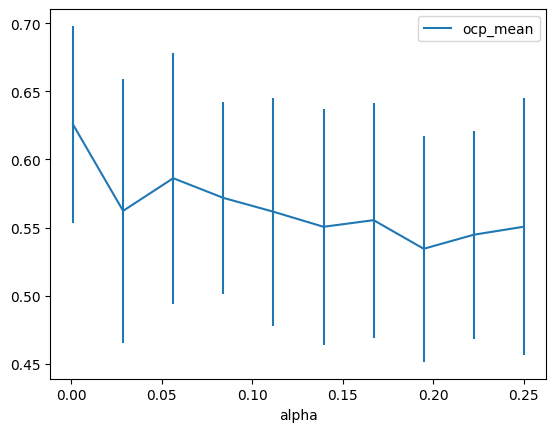

In [19]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

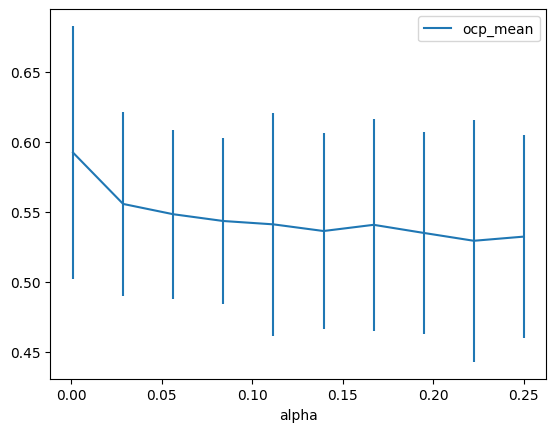

In [20]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

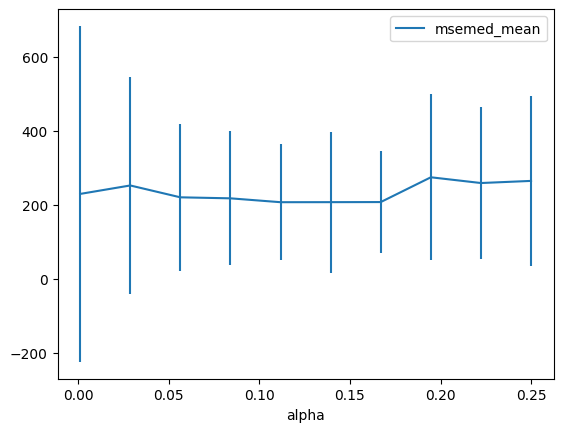

In [21]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

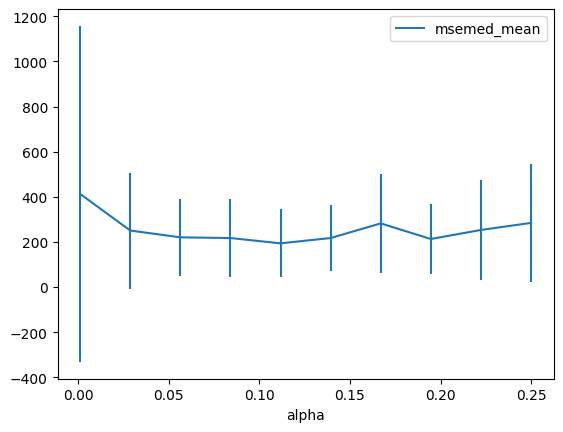

In [22]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha, though again there is a large error bar. We explore the low range of alpha in more detail, both with and without averaging. 

In [23]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.15, num=10)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r) 

0.001 True 0.5951829623132324 29.640719809993705
0.017555555555555557 True 0.5584157920410247 125.57537922429432
0.03411111111111111 True 0.5495013569892545 140.68273696033629
0.050666666666666665 True 0.5532283143251513 193.56605299074943
0.06722222222222222 True 0.5495806491152216 162.62792350606907
0.08377777777777778 True 0.5354731887503422 207.82621803517276
0.10033333333333333 True 0.553957717017066 163.12569076169845
0.11688888888888889 True 0.5600930454402737 156.22564218254348
0.13344444444444445 True 0.543475236966432 176.05693312399887
0.15 True 0.5340821417421114 200.15058073287776
0.001 False 0.5630383409195647 52.96288141717998
0.017555555555555557 False 0.5595187221974913 178.17889320010988
0.03411111111111111 False 0.5406730205776166 149.37899629638684
0.050666666666666665 False 0.5365788788728735 178.6471445229684
0.06722222222222222 False 0.5198566796853 224.18449898906755
0.08377777777777778 False 0.529663116743797 247.55005223817653
0.10033333333333333 False 0.53430

In [24]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.599107,0.090144,126.870944,211.777563
1,0.017556,True,0.554182,0.062399,349.154408,317.996942
2,0.034111,True,0.547674,0.059639,394.391215,383.871911
3,0.050667,True,0.533893,0.066538,457.571387,440.938516
4,0.067222,True,0.524486,0.033969,442.003616,474.004777


We again plot average OC_P mean and MSE median values, with error bars. 

<AxesSubplot: xlabel='alpha'>

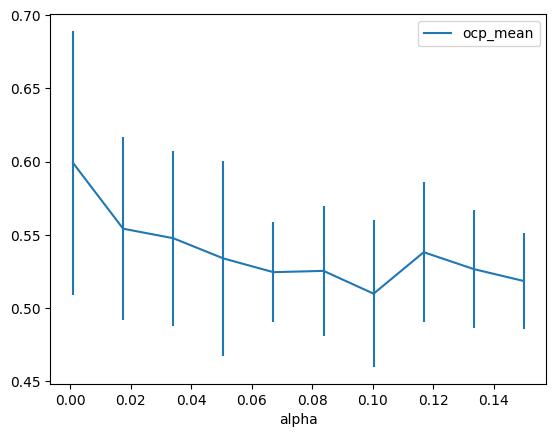

In [25]:
%matplotlib inline

df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

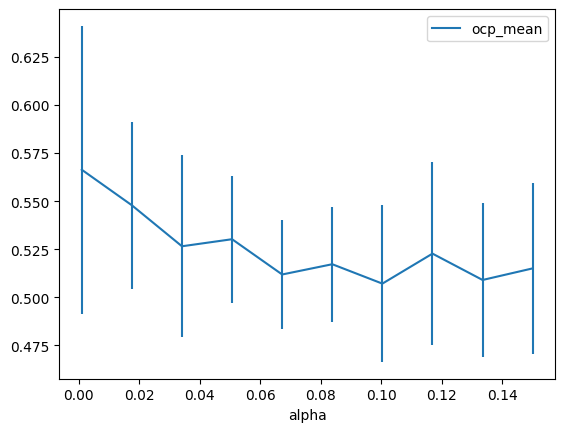

In [26]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

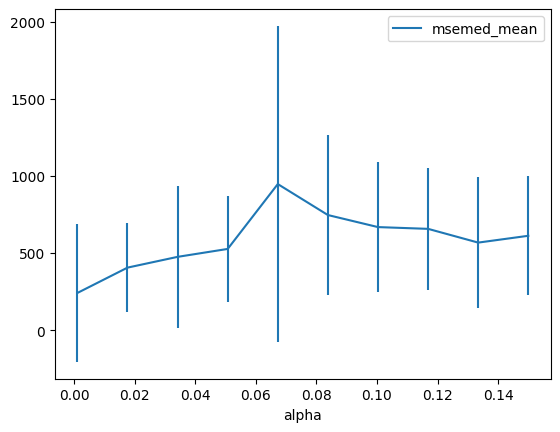

In [27]:
df[df.avg == False].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

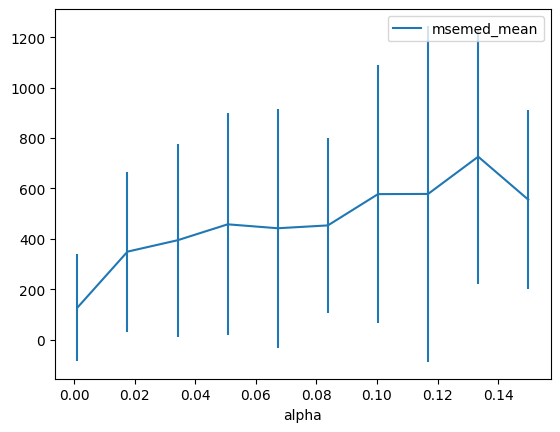

In [28]:
df[df.avg == True].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

We again look at the numbers.

In [29]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.599107,0.090144,126.870944,211.777563
1,0.017556,True,0.554182,0.062399,349.154408,317.996942
2,0.034111,True,0.547674,0.059639,394.391215,383.871911


In [30]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.566339,0.074798,241.583341,446.716891
11,0.017556,False,0.547846,0.043477,405.719008,289.402588
13,0.050667,False,0.530199,0.032994,526.815616,343.988045


In [31]:
df[df.avg == False].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.566339,0.074798,241.583341,446.716891
11,0.017556,False,0.547846,0.043477,405.719008,289.402588
12,0.034111,False,0.526525,0.047347,475.471176,461.003814


In [32]:
df[df.avg == True].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.599107,0.090144,126.870944,211.777563
1,0.017556,True,0.554182,0.062399,349.154408,317.996942
2,0.034111,True,0.547674,0.059639,394.391215,383.871911


### Parameters for the fitted model with seed dimensions


**BERT last 4 layers plus layer 16**

We again see large error bars, meaning that there is wide difference across sub-datasets. Still, the lowest values of alpha seem best both in terms of OC_P and MSE. In terms of both OC_P and MSE, the best value is at **alpha = 0.001, with averaging over seeds.** 

**BERT last 4 layers**

Best performance is for lowest values of alpha, and averaging seems to work better than not averaging, in all embedding spaces. The best value is at **alpha = 0.001, with averaging**

**BERT layer 16**

again we get the best performance for **alpha = 0.001, with averaging**

In [33]:
raise Exception("stop")

Exception: stop

# Combined model: seeds as words and dimensions

We fix jitter, offset, and averaging to the best values determined above as they don't seem to have made much of a difference.


In [34]:
average_vals = [True]
alpha_vals= np.linspace(0.001, 0.15, num=10)
jitter_vals = [True]
offset_vals= [ 0.3]


results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    
                    ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
                    _, mse_med, _ = eval_summary_by(theseresults, "mse")
                    print(alphaval, avgval, oval, jval, ocp_mean, mse_med)
            
            
                    for r in theseresults:
                        r.update({"alpha":alphaval, "avg": avgval, "offset": oval, "j": jval})
                        results[ (str(alphaval), str(avgval))].append(r) 




0.001 True 0.3 True 0.7091758450384827 3.2835845011613016
0.017555555555555557 True 0.3 True 0.6618306047509337 2.4588106499146094
0.03411111111111111 True 0.3 True 0.6522422454508158 4.620414034788816
0.050666666666666665 True 0.3 True 0.6333175542961051 5.549439082734642
0.06722222222222222 True 0.3 True 0.6175848728039953 6.582434895174229
0.08377777777777778 True 0.3 True 0.6127026361816066 7.38734665326754
0.10033333333333333 True 0.3 True 0.6032725575557413 9.05702776288619
0.11688888888888889 True 0.3 True 0.5915811687650817 11.617801541849252
0.13344444444444445 True 0.3 True 0.5811115062679822 12.684965762315706
0.15 True 0.3 True 0.5663271663494688 15.228687701168692
0.001 True 0.3 True 0.6845947079686567 3.816411987977768
0.017555555555555557 True 0.3 True 0.6301364183958611 4.377819985925678
0.03411111111111111 True 0.3 True 0.624909108660031 6.2462967148608435
0.050666666666666665 True 0.3 True 0.6063444682113371 8.72326578405168
0.06722222222222222 True 0.3 True 0.5852449

In [35]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg", "offset", "j"]))
df.head()


,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.3,True,0.694295,0.070653,3.442897,1.482579
1,0.017556,True,0.3,True,0.653125,0.050197,3.873193,2.016991
2,0.034111,True,0.3,True,0.640821,0.050594,5.518837,2.634540
3,0.050667,True,0.3,True,0.617737,0.044962,7.419722,2.829276
4,0.067222,True,0.3,True,0.604156,0.048046,10.285070,5.247938


## Plotting the results



<AxesSubplot: xlabel='alpha'>

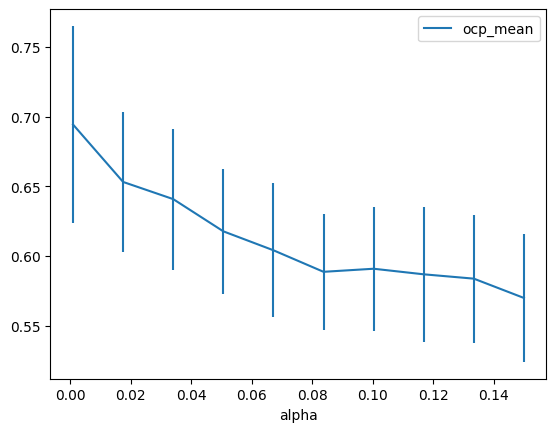

In [36]:
df.plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

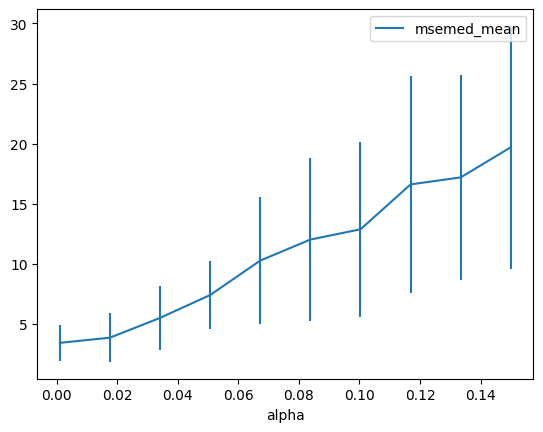

In [37]:
df.plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

In [38]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.3,True,0.694295,0.070653,3.442897,1.482579
1,0.017556,True,0.3,True,0.653125,0.050197,3.873193,2.016991
2,0.034111,True,0.3,True,0.640821,0.050594,5.518837,2.634540
3,0.050667,True,0.3,True,0.617737,0.044962,7.419722,2.829276
4,0.067222,True,0.3,True,0.604156,0.048046,10.285070,5.247938


In [39]:
df.sort_values(by = "msemed_mean", ascending = True).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.3,True,0.694295,0.070653,3.442897,1.482579
1,0.017556,True,0.3,True,0.653125,0.050197,3.873193,2.016991
2,0.034111,True,0.3,True,0.640821,0.050594,5.518837,2.634540
3,0.050667,True,0.3,True,0.617737,0.044962,7.419722,2.829276
4,0.067222,True,0.3,True,0.604156,0.048046,10.285070,5.247938


### Parameters for the fitted model with seed words and seed dimensions

**BERT last 4 layers plus layer 16**

Both OC_P and MSE have a clear best value at **alpha = 0.02**. We use **averaging, no jitter, and an offset of 0.3**,

**BERT last 4 layers**

Both OC_P and MSE have a clear best value at **alpha = 0.02**. We use **averaging, jitter, and an offset of 0.7**,

**BERT layer 16**

Best performance, in terms of both OC_P and MSE, is at **alpha = 0.001**. We use **averaging, jitter ,and an offset of 0.3.**